In [49]:
from src.data import *
from src.embeddings import *
from src.orcml import *
from src.plotting import *
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
exp_name = 'orcml_5_24'

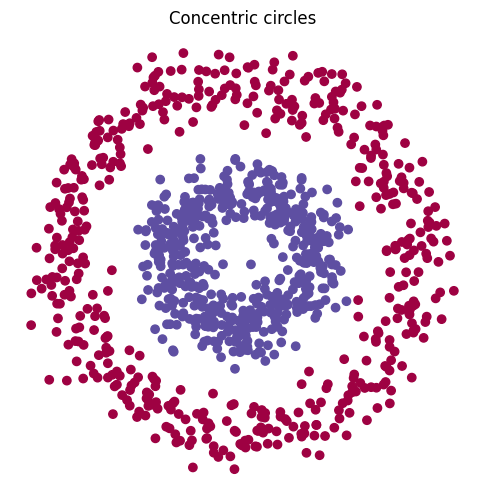

In [55]:
%autoreload 2
n_points = 1000
X, color = concentric_circles(n_points, factor=0.4, noise=0.1)
plot_data_2D(X, color, 'Concentric circles', exp_name=exp_name, filename='concentric_circles.png')

/home/tristan/envs/orcml/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


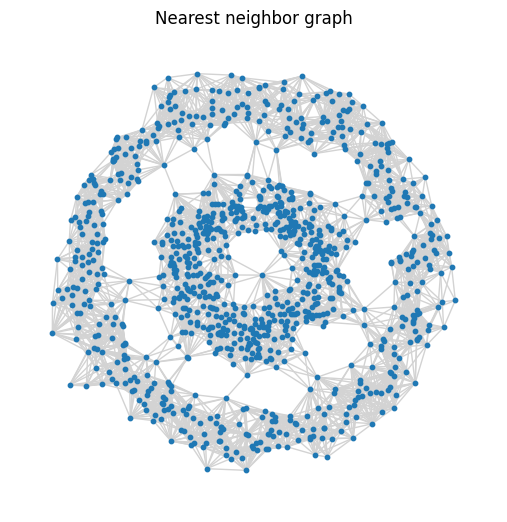

In [57]:
n_neighbors = 20
G, A = make_prox_graph(X, mode='nbrs', n_neighbors=n_neighbors)
plot_graph_2D(X, G, 'Nearest neighbor graph', exp_name=exp_name, filename='concentric_circles_nbrs.png')

/home/tristan/envs/orcml/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


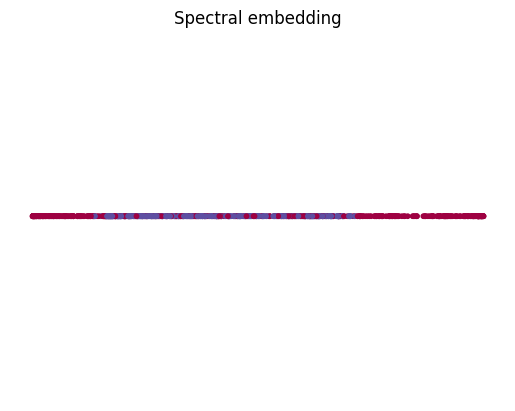

<Figure size 640x480 with 0 Axes>

In [58]:
# run spectral embedding
Y = spectral_embedding(A, n_components=1)
plot_emb(Y, color, 'Spectral embedding', exp_name=exp_name, filename='concentric_circles_spectral_emb.png')

/home/tristan/envs/orcml/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


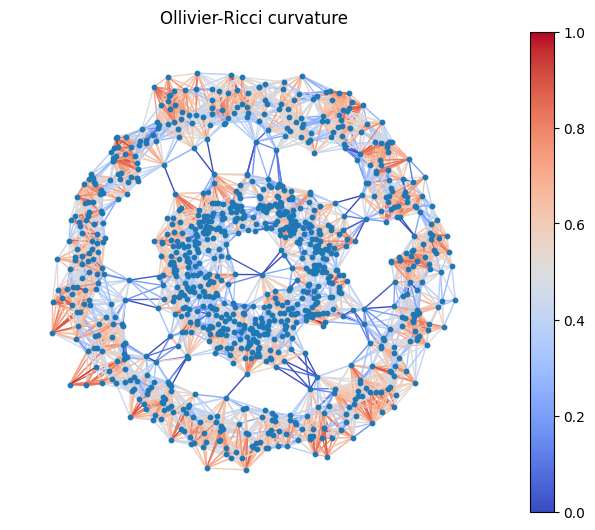

In [59]:
G_orc, orc_weights = graph_orc(G, weight='weight', alpha=0.5)
plot_graph_2D(X, G_orc, 'Ollivier-Ricci curvature', edge_color=orc_weights, colorbar=True, exp_name=exp_name, filename='concentric_circles_orc.png')

Percentage of edges preserved: 0.6467671558905196


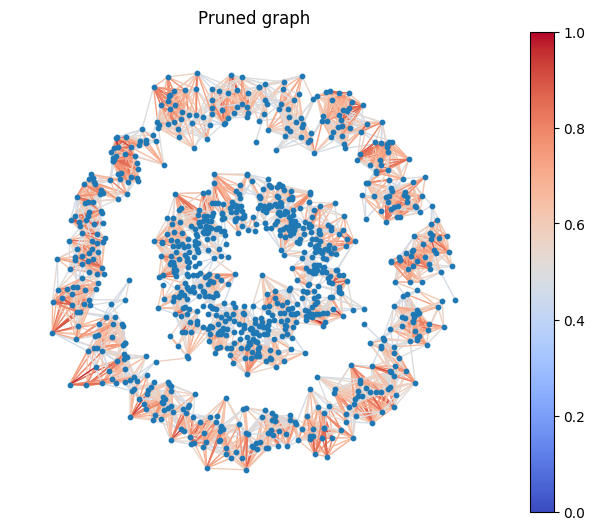

In [64]:
threshold = 0.45
pruned = prune(G_orc, threshold, X, color)
plot_graph_2D(X, pruned['G_pruned'], 'Pruned graph', edge_color=pruned['preserved_orcs'], colorbar=True, exp_name=exp_name, filename='concentric_circles_pruned_orc.png')

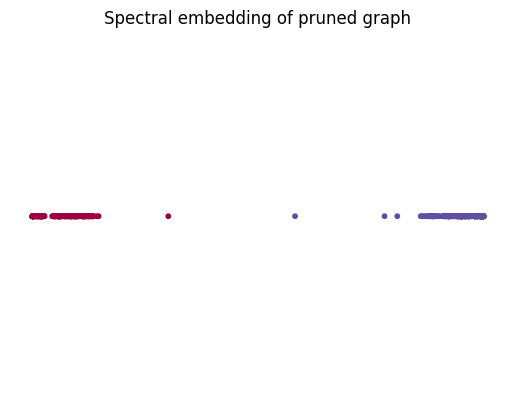

<Figure size 640x480 with 0 Axes>

In [65]:
# run spectral embedding on pruned graph

A = nx.adjacency_matrix(pruned['G_pruned']).toarray()
Y = spectral_embedding(A, n_components=1)

plot_emb(Y, color[nx.nodes(pruned['G_pruned'])], 'Spectral embedding of pruned graph', exp_name=exp_name, filename='concentric_circles_pruned_spectral_emb.png')

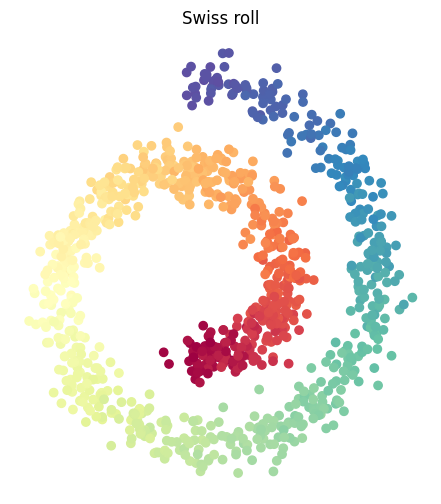

In [67]:
# swiss roll
swiss_roll_data, color = swiss_roll(n_points, noise=0.95, dim=2)
plot_data_2D(swiss_roll_data, color, 'Swiss roll', exp_name=exp_name, filename='swiss_roll.png')

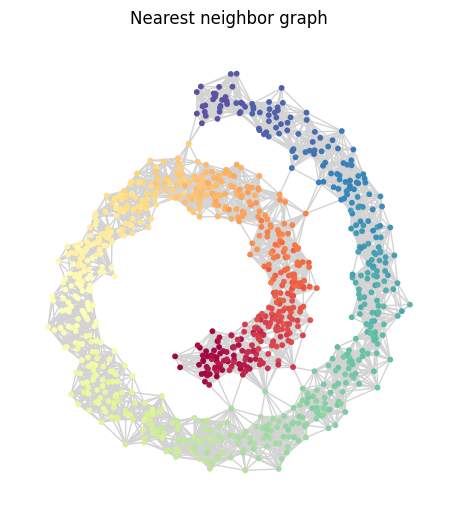

In [69]:
n_neighbors = 20
G, A = make_prox_graph(swiss_roll_data, mode='nbrs', n_neighbors=n_neighbors)
plot_graph_2D(swiss_roll_data, G, 'Nearest neighbor graph', node_color=color[nx.nodes(G)], exp_name=exp_name, filename='swiss_roll_nbrs.png')

/home/tristan/envs/orcml/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


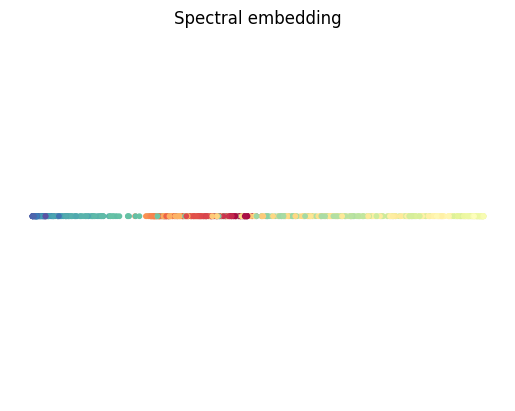

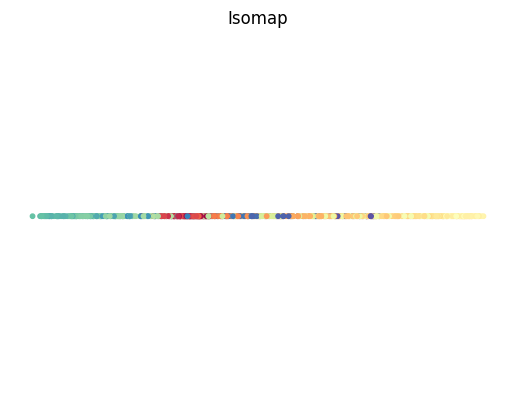

<Figure size 640x480 with 0 Axes>

In [70]:
n_components = 1
Y_spectral = spectral_embedding(A, n_components=n_components)
plot_emb(Y_spectral, color, 'Spectral embedding', exp_name=exp_name, filename='swiss_roll_spectral_emb.png')

Y_isomap = isomap(A, n_components=1)
plot_emb(Y_isomap, color, 'Isomap', exp_name=exp_name, filename='swiss_roll_isomap.png')

/home/tristan/envs/orcml/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


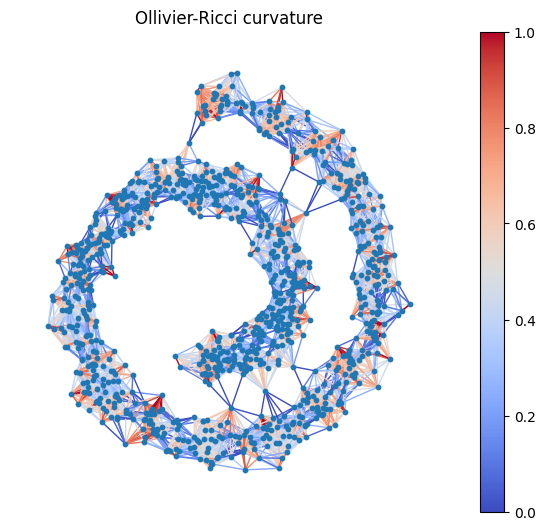

In [71]:
G_orc, orc_weights = graph_orc(G, weight='weight', alpha=0.5)
plot_graph_2D(swiss_roll_data, G_orc, 'Ollivier-Ricci curvature', edge_color=orc_weights, colorbar=True, exp_name=exp_name, filename='swiss_roll_orc.png')

Percentage of edges preserved: 0.9039831443764422


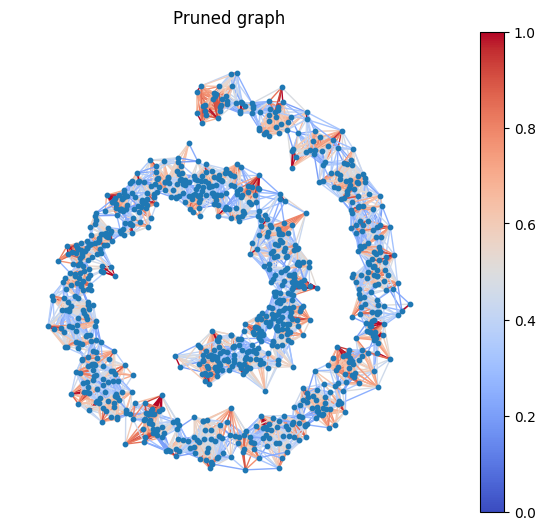

In [72]:
threshold = 0.2
pruned = prune(G_orc, threshold, swiss_roll_data, color)
plot_graph_2D(swiss_roll_data, pruned['G_pruned'], 'Pruned graph', edge_color=pruned['preserved_orcs'], colorbar=True, exp_name=exp_name, filename='swiss_roll_pruned_orc.png')

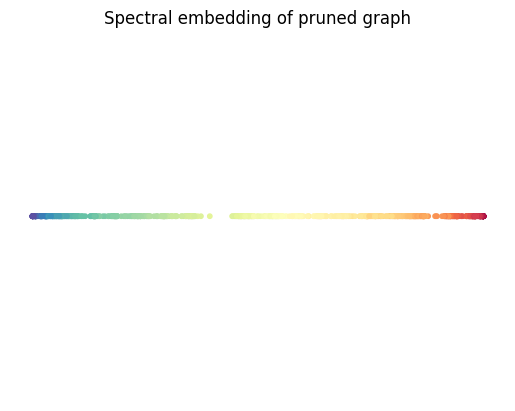

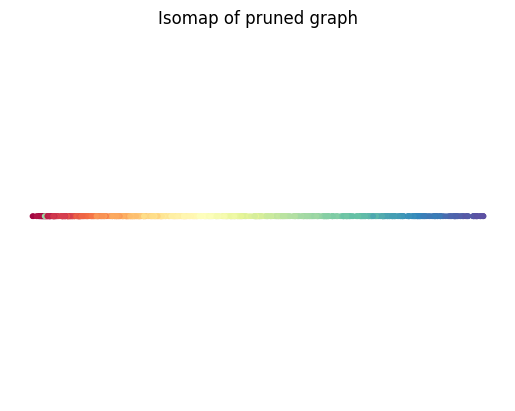

<Figure size 640x480 with 0 Axes>

In [73]:
%autoreload 2
# run spectral embedding on pruned graph
A = nx.adjacency_matrix(pruned['G_pruned']).toarray()
colors = pruned['color_pruned'][list(pruned['G_pruned'])]
Y = spectral_embedding(A, n_components=1)
plot_emb(Y, colors, 'Spectral embedding of pruned graph', exp_name=exp_name, filename='swiss_roll_pruned_spectral_emb.png')

# run isomap on pruned graph
Y = isomap(A, n_components=1)
plot_emb(Y, colors, 'Isomap of pruned graph', exp_name=exp_name, filename='swiss_roll_pruned_isomap.png')